In [1]:
### pyDANDIA, PyTorch comparison ###
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import norm
from astropy.stats import mad_std
import seaborn as sns
import pandas as pd
%matplotlib inline

In [2]:
# load data - pyDANDIA is the Bramich 2008 implementation (B08 in the paper)
# n.b. altconvtest files used 1e-6 tolerance condition on ALL kernel pixels
pyDANDIA_data1 = np.genfromtxt('pyDANDIA_S10_PSFfit_FullLnL_lossconvtest.txt')
PyTorch_data1 = np.genfromtxt('PyTorch_S10_PSFfit_FullLnL_lossconvtest.txt')
print(pyDANDIA_data1.shape, PyTorch_data1.shape)

# data set 2 on external drive
#external_drive = '/media/jah94/Seagate_Expansion_Drive#2/Simulation_test_pyDANDIA/code'
#pyDANDIA_data2 = np.genfromtxt(os.path.join(external_drive,'pyDANDIA_S10_PSFfit_bright_star_otherPC.txt'))
#PyTorch_data2 = np.genfromtxt(os.path.join(external_drive,'PyTorch_S10_PSFfit_bright_star_otherPC.txt'))
#print(pyDANDIA_data2.shape, PyTorch_data2.shape)

(22974, 14) (22952, 14)


In [3]:
# clean data - make sure we're comparing identical simulations
def clean_data(pyDANDIA_data, PyTorch_data):
    
    pyDANDIA_image_params = pyDANDIA_data[:, [7,8,9,10,11,12,13,13]]
    PyTorch_image_params = PyTorch_data[:, [7,8,9,10,11,12,13,13]]
    mask = []
    
    # 11325 - something's up with this index, so avoid this
    for indx in range(0, len(pyDANDIA_image_params)):
        if pyDANDIA_image_params[indx] in PyTorch_image_params: # and indx != 11325:
            mask.append(0)
        else:
            mask.append(1)

    mask = np.array(mask)
    pyDANDIA_data = pyDANDIA_data[:, [0,1,2,3,4,5,6,7,8,9,10,11,12, 13]][np.where(mask == 0)]
    print(pyDANDIA_data.shape, PyTorch_data.shape)
    
    #if pyDANDIA_data.shape[0] != PyTorch_data.shape[0]:
    #    pyDANDIA_image_params = pyDANDIA_data[:, [7,8,9,10,11,12,13,13]]
    #    PyTorch_image_params = PyTorch_data[:, [7,8,9,10,11,12,13,13]]
    #    for index in range(0, len(pyDANDIA_image_params)):
    #        if np.sum(pyDANDIA_image_params[index]) != np.sum(PyTorch_image_params[index]):
    #            print(index)
                
    # check - this is ungodly... why do I need to do this now (worked fine before!!!!!)
    pyDANDIA_image_params = pyDANDIA_data[:, [7,8,9,10,11,12,13,13]]
    PyTorch_image_params = PyTorch_data[:, [7,8,9,10,11,12,13,13]]
    diff = np.where(np.abs(pyDANDIA_image_params - PyTorch_image_params))
    rejects = np.unique(diff[0])
    for i in range(0, len(pyDANDIA_data)):
        if i in rejects:
            pyDANDIA_data[i] = np.zeros(pyDANDIA_data[i].shape)
            PyTorch_data[i] = np.zeros(PyTorch_data[i].shape)
    
    shape = (pyDANDIA_data.shape[0]-len(rejects), pyDANDIA_data.shape[1])
    pyDANDIA_data = pyDANDIA_data[pyDANDIA_data != 0].reshape(shape)
    PyTorch_data = PyTorch_data[PyTorch_data != 0].reshape(shape)
    
    pyDANDIA_image_params = pyDANDIA_data[:, [7,8,9,10,11,12,13,13]]
    PyTorch_image_params = PyTorch_data[:, [7,8,9,10,11,12,13,13]]
   
    print((pyDANDIA_image_params == PyTorch_image_params).all())
    print(pyDANDIA_data.shape, PyTorch_data.shape)

    return pyDANDIA_data, PyTorch_data

pyDANDIA_data1, PyTorch_data1 = clean_data(pyDANDIA_data1, PyTorch_data1)
#pyDANDIA_data2, PyTorch_data2 = clean_data(pyDANDIA_data2, PyTorch_data2)

(22952, 14) (22952, 14)
True
(22952, 14) (22952, 14)


In [4]:
# concenate datasets
#pyDANDIA_data = np.vstack((pyDANDIA_data1, pyDANDIA_data2))
#PyTorch_data = np.vstack((PyTorch_data1, PyTorch_data2))
pyDANDIA_data, PyTorch_data = pyDANDIA_data1, PyTorch_data1
print(pyDANDIA_data.shape, PyTorch_data.shape)

(22952, 14) (22952, 14)


In [5]:
## deal with nans
#a[~np.isnan(a).any(axis=1)]
pyDANDIA_data = pyDANDIA_data[~np.isnan(PyTorch_data).any(axis=1)]
PyTorch_data = PyTorch_data[~np.isnan(PyTorch_data).any(axis=1)]
print(pyDANDIA_data.shape, PyTorch_data.shape)

(22899, 14) (22899, 14)


In [6]:
# create dataframe

def numpy_to_DataFrame(array):
    df = pd.DataFrame(array, columns=['$P$', 'B0', 'MSE', 'MFB', 'MFV',
                                      'F_meas', 'var_min', 'Stellar Density', 'phi_r',
                                      'sky', 'phi_k', 'SNR_ref', '$\mathrm{SNR}_{I}$',
                                       '$\mathcal{F}_{\mathrm{Max}}/\mathcal{F}_{\mathrm{Total}}$'])

    
    df['$\mathcal{F}_{\mathrm{measured}}/\sigma_{\mathrm{min}}$'] = df['F_meas']/np.sqrt(df['var_min'])
    
    ## drop unecessary columns
    df = pd.DataFrame.drop(df, columns=['B0', 'F_meas', 'var_min', 'sky'])
    
    # categories
    # SNR: 3 categories
    # 8 < $\mathrm{SNR}_{I}$ < 40, 40 < $\mathrm{SNR}_{I}$ < 200, 200 < $\mathrm{SNR}_{I}$ < 1000
    cat1, cat2, cat3 = '8 < $\mathrm{SNR}_{I}$ < 40', '40 < $\mathrm{SNR}_{I}$ < 200', '200 < $\mathrm{SNR}_{I}$ < 1000'

    df['SNR category'] = 0
    df['SNR category'][(8. < df['$\mathrm{SNR}_{I}$']) & (df['$\mathrm{SNR}_{I}$'] < 40.)] = cat1
    df['SNR category'][(40. < df['$\mathrm{SNR}_{I}$']) & (df['$\mathrm{SNR}_{I}$'] < 200.)] = cat2
    df['SNR category'][(200. < df['$\mathrm{SNR}_{I}$']) & (df['$\mathrm{SNR}_{I}$'] < 1000.)] = cat3

    df = df[df['SNR category']!= 0]

    # set to categorical type
    df['SNR category'] = df['SNR category'].astype('category')
    
    # drop more uneccesary columns
    df = pd.DataFrame.drop(df, columns=['SNR_ref', '$\mathrm{SNR}_{I}$', 'phi_k', 'phi_r',
                                       '$\mathcal{F}_{\mathrm{Max}}/\mathcal{F}_{\mathrm{Total}}$',
                                       'Stellar Density'])
    
    

    return df

pyDANDIA_df = numpy_to_DataFrame(pyDANDIA_data)
PyTorch_df = numpy_to_DataFrame(PyTorch_data)

/home/jah94/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
# fit and photometric accuracy metrics for the different SNR regimes
cats = ['8 < $\mathrm{SNR}_{I}$ < 40', '40 < $\mathrm{SNR}_{I}$ < 200', '200 < $\mathrm{SNR}_{I}$ < 1000']
def metrics(df):
    
    output_metrics = np.array([])
    
    for cat in cats:
        
        # SNR category
        print('\nCategory:', cat)
        
        # fit quality metrics
        Ps = df['$P$'][df['SNR category'] == cat]
        MSEs = df['MSE'][df['SNR category'] == cat]
        MFBs = df['MFB'][df['SNR category'] == cat]
        MFVs = df['MFV'][df['SNR category'] == cat]
        print('P:', np.nanmedian(Ps))
        print('MSE:', np.nanmedian(MSEs))
        print('MFB:', np.nanmedian(MFBs))
        print('MFV:', np.nanmedian(MFVs))
        
        # photometric accuracy metrics
        nr = df['$\mathcal{F}_{\mathrm{measured}}/\sigma_{\mathrm{min}}$'][df['SNR category'] == cat]
                
        # remove bad outliers
        sigma = mad_std(nr)
        nr = nr[nr < np.nanmedian(nr) + 5*sigma]
        nr = nr[nr > np.nanmedian(nr) - 5*sigma]
        
        MPB = 1./len(nr) * np.nansum(nr)
        MPV = 1./(len(nr) - 1) * np.nansum((nr - MPB)**2)
        MedPB = np.nanmedian(nr)
        MedPV = (mad_std(nr))**2
        print('N_set:', len(nr))
        print('MPB:', MPB)
        print('MPV:', MPV)
        print('MedPB:', MedPB)
        print('MedPV:', MedPV)
        
        output_metrics = np.append(output_metrics, [np.nanmedian(Ps), np.nanmedian(MSEs),  np.nanmedian(MFBs),
                                                   np.nanmedian(MFVs), MPB, MPV])
        
        
    return output_metrics

print('\npyDANDIA')        
pyDANDIA_metrics = metrics(pyDANDIA_df)
print('\nPyTorch')
PyTorch_metrics = metrics(PyTorch_df)


pyDANDIA

Category: 8 < $\mathrm{SNR}_{I}$ < 40
P: 0.9977723294556358
MSE: 520.4143455259775
MFB: -0.00013468990067758558
MFV: 0.9733015282724145
N_set: 5363
MPB: 0.16600192555469032
MPV: 0.7146020279496504
MedPB: 0.18750645608142505
MedPV: 0.5522676591984039

Category: 40 < $\mathrm{SNR}_{I}$ < 200
P: 0.9984077317786484
MSE: 548.7346886065714
MFB: -0.0003424097737523207
MFV: 0.9856035131845879
N_set: 5695
MPB: -0.4530393677954758
MPV: 1.0252184221937017
MedPB: -0.3508584250766621
MedPV: 0.8029938319590285

Category: 200 < $\mathrm{SNR}_{I}$ < 1000
P: 0.998455176100296
MSE: 731.3444013918559
MFB: -0.0012425183102462121
MFV: 1.043694423022274
N_set: 6113
MPB: -1.2915125548729076
MPV: 2.3727496221795663
MedPB: -1.091388168231531
MedPV: 1.7888686190193555

PyTorch

Category: 8 < $\mathrm{SNR}_{I}$ < 40
P: 0.9946774542331696
MSE: 520.4331865747833
MFB: 0.0004584895507963577
MFV: 0.9734400010289965
N_set: 5357
MPB: 0.15876837080066364
MPV: 0.7189266605085517
MedPB: 0.1884655736557204
MedPV

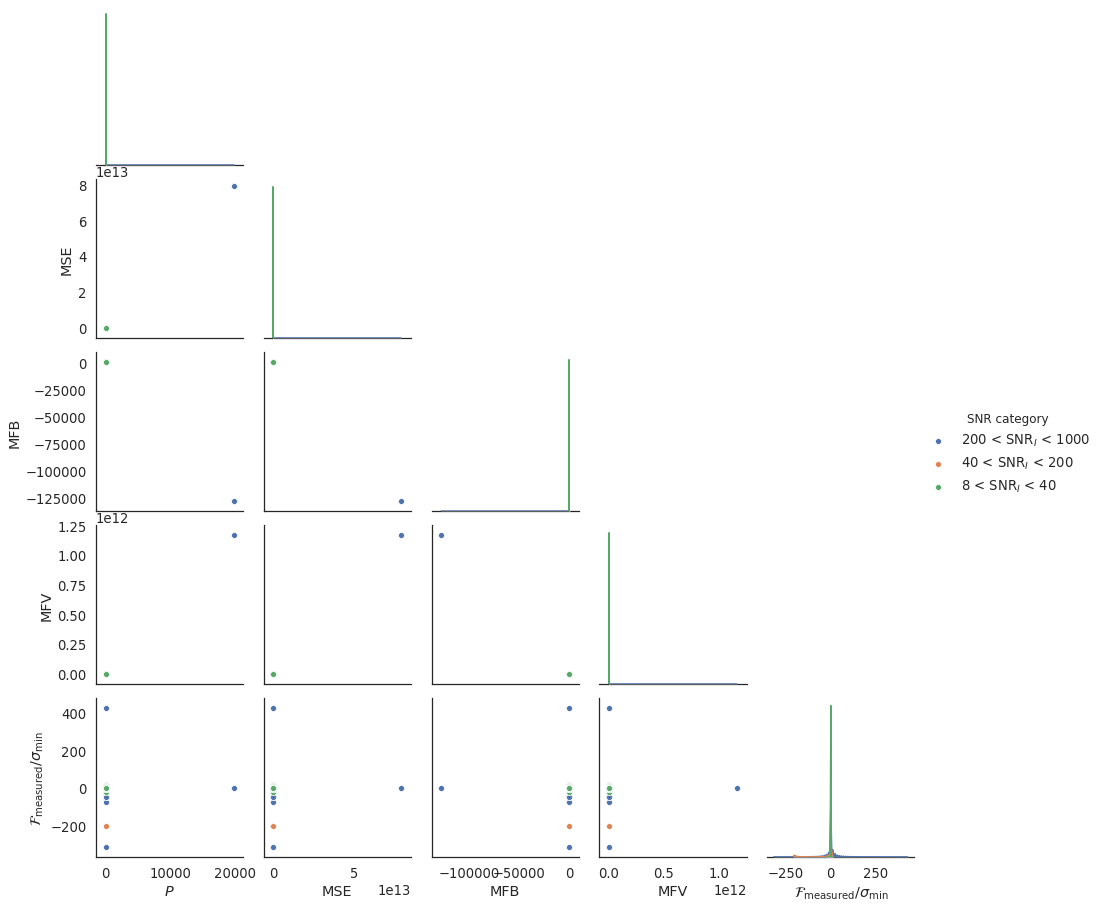

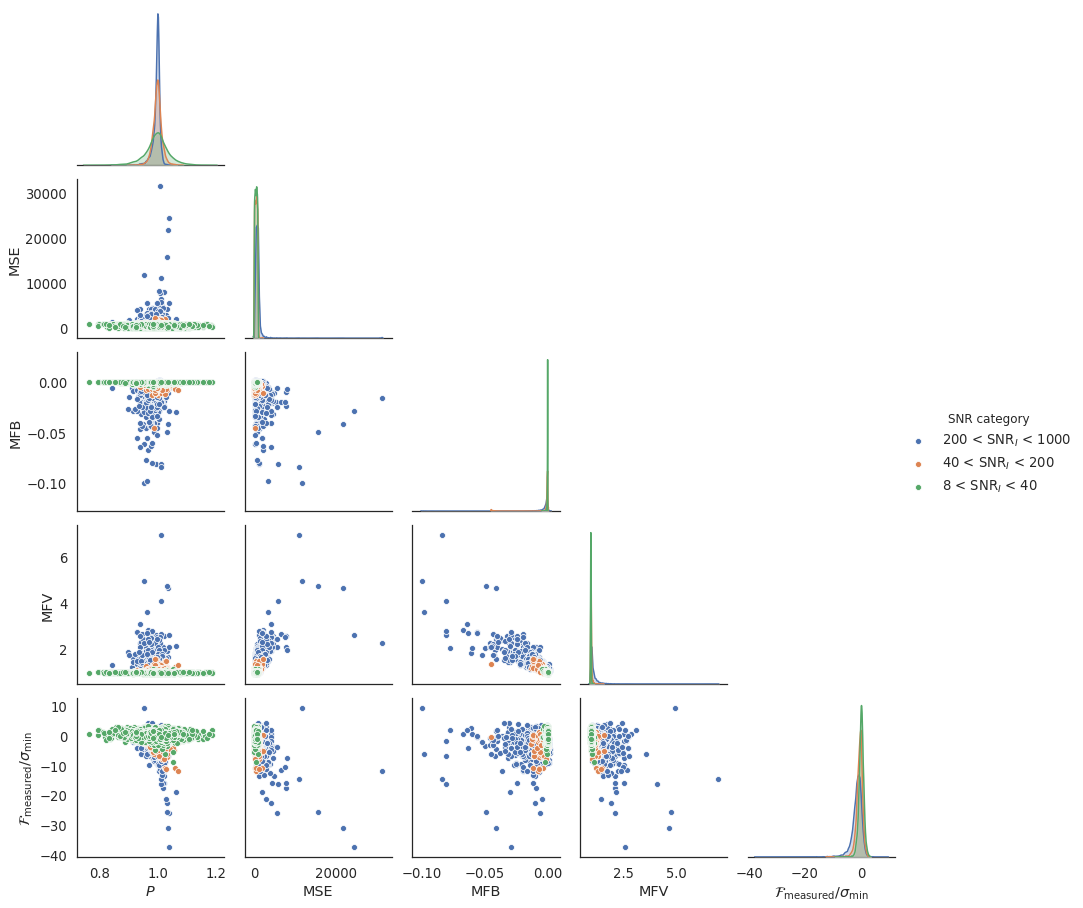

In [8]:
# pairplot
sns.set(context='notebook', font_scale = 1.2, style='white')
sns.pairplot(PyTorch_df, hue='SNR category', corner=True)
plt.show()

sns.set(context='notebook', font_scale = 1.2, style='white')
sns.pairplot(pyDANDIA_df, hue='SNR category', corner=True)
plt.show()
#plt.savefig('Corner_plot_PyTorchDIA_simulation_results.png')

In [9]:
# for clarity when plotting, exclude bad outliers
def clip(df):
    
    labels = ['$P$', 'MSE', 'MFB', 'MFV', '$\mathcal{F}_{\mathrm{measured}}/\sigma_{\mathrm{min}}$']
    
    for label in labels:
        column = df[label]
        std = mad_std(column)
        sigma = 5
        column[column > np.median(column) + sigma*std] = 0
        column[column < np.median(column) - sigma*std] = 0
          
    clipped_df = df[df != 0]
    
    return clipped_df
        
PyTorch_df_clipped = clip(PyTorch_df)

/home/jah94/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/jah94/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


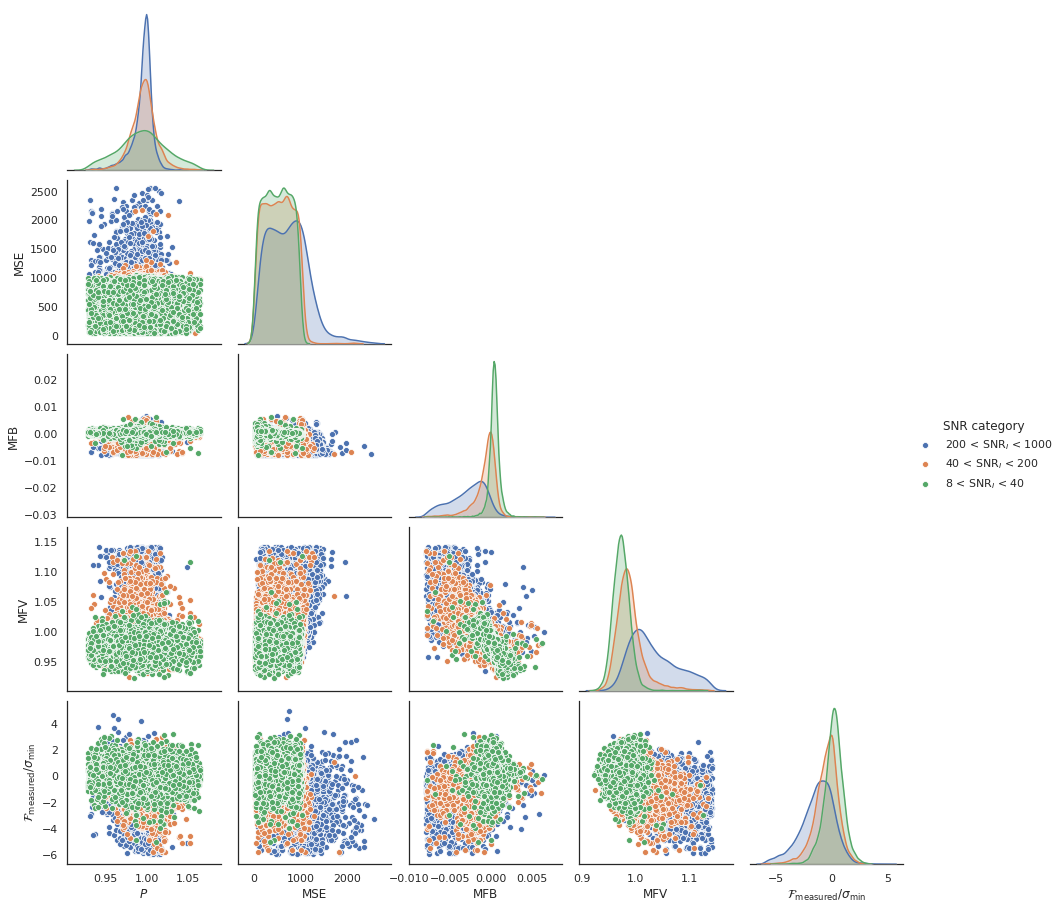

In [10]:
# pairplot
sns.set(context='notebook', font_scale = 1, style='white')
sns.pairplot(PyTorch_df_clipped, hue='SNR category', corner=True)

/home/jah94/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jah94/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/jah94/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by In

1125
1000


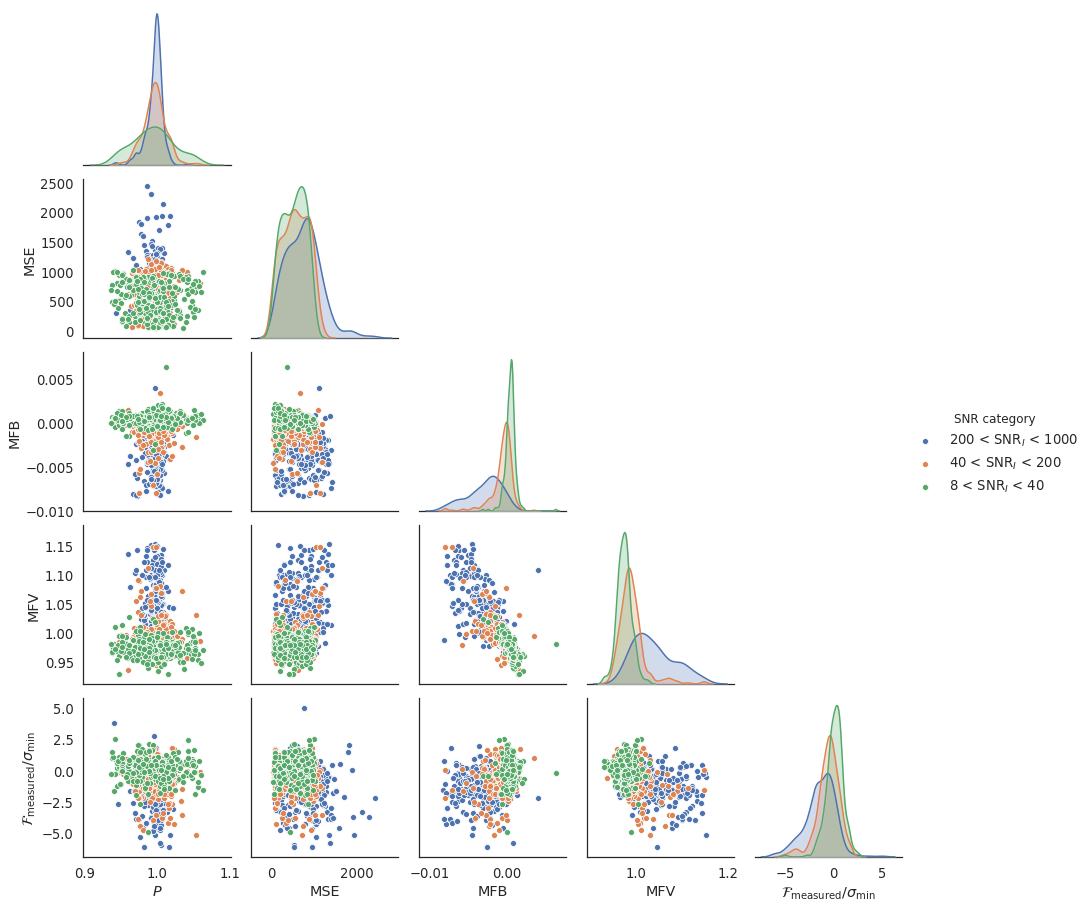

In [11]:
# or a representative sub-sample??
np.random.seed(42)
sample = np.random.randint(0, len(PyTorch_data), 1500)
PyTorch_data_sample = PyTorch_data[sample]
sample_df = numpy_to_DataFrame(PyTorch_data_sample)
clipped_sample_df = clip(sample_df)
print(len(clipped_sample_df))
clipped_sample_df = clipped_sample_df[0:1000]
print(len(clipped_sample_df))
# pairplot
sns.set(context='notebook', font_scale = 1.2, style='white')
pp = sns.pairplot(clipped_sample_df, hue='SNR category', corner=True)
pp.axes[2,0].set_ylim(-0.01,0.008)
#pp.axes[4,2].tick_params(labelsize=12)
plt.savefig('Corner_plot_PyTorchDIA_simulation_results.png', bbox_inches='tight')

In [18]:
### difference column for paper ####
# absolute difference
diff = np.abs(PyTorch_metrics - pyDANDIA_metrics)
for d in diff:
    print(d)

0.003094875222466209
0.018841048805825267
0.0005931794514739433
0.00013847275658207536
0.007233554754026678
0.0043246325589012535
0.0014004213881759764
0.38518516930878377
1.0770289539855423e-05
0.00012503050206102984
0.026106048796422587
0.060219346627233605
0.0006581041665496556
5.136100232685067
0.002277944939760388
0.004838800925321962
0.08918330367535798
0.3201871203628426


In [19]:
# relative difference
rel_diff = np.abs((PyTorch_metrics - pyDANDIA_metrics)/pyDANDIA_metrics)
for d in rel_diff:
    print(d)

0.0031017849774955275
3.620393820386102e-05
4.404038079245961
0.00014227117964960047
0.043575125588790474
0.006051805606135167
0.0014026547908249335
0.0007019515574765343
0.03145438701071081
0.00012685679422655793
0.0576242389782959
0.058738065297714616
0.0006591223945776293
0.007022820196490618
1.8333290712705876
0.0046362238013211024
0.06905337725047059
0.13494349229680808
